dust storm analysis by processing and plotting CL61 ceilometer data from three sites (ATMOS, CCICS, and NEIU) using xarray

In [1]:
import os
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import act  # Ensure ACT is installed: pip install act-atmos
from datetime import datetime
import pyart



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [11]:

# Base path to data and list of site names
base_path = "/Users/bhupendra/projects/crocus/data/dust-storm/"
sites = ["ATMOS", "CCICS", "NEIU"]

# Variables to correct
variables = ['beta_att', 'p_pol', 'x_pol', 'linear_depol_ratio']

# Store datasets for each site
site_datasets = {}



In [12]:


def filter_files(site, base_path):
    start_dt = datetime(2025, 5, 16, 22, 0)
    end_dt   = datetime(2025, 5, 17, 2, 0)

    filtered_files = []
    for f in glob.glob(os.path.join(base_path, site, "*.nc")):
        fname = os.path.basename(f)
        try:
            dt_str = fname.split("_")[1] + fname.split("_")[2].split(".")[0]
            dt = datetime.strptime(dt_str, "%Y%m%d%H%M%S")
            if start_dt <= dt <= end_dt:
                filtered_files.append(f)
        except (IndexError, ValueError):
            print(f"Skipping malformed filename: {fname}")

    # Sort and return
    filtered_files.sort()
    return filtered_files



In [6]:
datetime(2025, 5, 16, 20, 0)

datetime.datetime(2025, 5, 16, 20, 0)

In [7]:
filter_files("ATMOS", base_path)

['/Users/bhupendra/projects/crocus/data/dust-storm/ATMOS/cmscl6004_20250516_220341.nc',
 '/Users/bhupendra/projects/crocus/data/dust-storm/ATMOS/cmscl6004_20250516_220840.nc',
 '/Users/bhupendra/projects/crocus/data/dust-storm/ATMOS/cmscl6004_20250516_221341.nc',
 '/Users/bhupendra/projects/crocus/data/dust-storm/ATMOS/cmscl6004_20250516_221841.nc',
 '/Users/bhupendra/projects/crocus/data/dust-storm/ATMOS/cmscl6004_20250516_222341.nc',
 '/Users/bhupendra/projects/crocus/data/dust-storm/ATMOS/cmscl6004_20250516_222841.nc',
 '/Users/bhupendra/projects/crocus/data/dust-storm/ATMOS/cmscl6004_20250516_223341.nc',
 '/Users/bhupendra/projects/crocus/data/dust-storm/ATMOS/cmscl6004_20250516_223840.nc',
 '/Users/bhupendra/projects/crocus/data/dust-storm/ATMOS/cmscl6004_20250516_224340.nc',
 '/Users/bhupendra/projects/crocus/data/dust-storm/ATMOS/cmscl6004_20250516_224841.nc',
 '/Users/bhupendra/projects/crocus/data/dust-storm/ATMOS/cmscl6004_20250516_225340.nc',
 '/Users/bhupendra/projects/croc

In [13]:
for site in sites:
    file_path = filter_files(site, base_path)
    if not file_path:
        print(f"No files found for site: {site}")
        continue

    print(f"Loading data for site: {site}...")
    ds = xr.open_mfdataset(file_path, combine='by_coords')
    ds.sortby('time')
    # Apply ceilometer corrections
    for var in variables:
        if var != 'linear_depol_ratio':
            ds = act.corrections.correct_ceil(ds, var_name=var)

    # Compute linear depolarization ratio
    ds["linear_depol_ratio"] = ds["x_pol"] / (ds["x_pol"] + ds["p_pol"])

    # Add derived range and cloud height variables (in km)
    ds = ds.assign(range_km=ds['range'] / 1000)
    ds = ds.assign(sky_condition_cloud_layer_heights_km=ds['sky_condition_cloud_layer_heights'] / 1000)
    ds['range_km'].attrs['units'] = 'km'
    ds = ds.swap_dims({'range': 'range_km'})

    # Store in dictionary
    site_datasets[site] = ds
    print(f"Dataset for {site} loaded with shape {ds.dims}")


Loading data for site: ATMOS...
Dataset for ATMOS loaded with shape FrozenMappingWarningOnValuesAccess({'time': 240, 'layer': 5, 'range_km': 3276})
Loading data for site: CCICS...
Dataset for CCICS loaded with shape FrozenMappingWarningOnValuesAccess({'time': 240, 'layer': 5, 'range_km': 3276})
Loading data for site: NEIU...
Dataset for NEIU loaded with shape FrozenMappingWarningOnValuesAccess({'time': 240, 'layer': 5, 'range_km': 3276})


In [14]:
def plot_cloud_heights(ax, ds, color='black'):
    """
    Plots cloud layer heights as small white '~' scatter markers.
    """
    if 'sky_condition_cloud_layer_heights_km' not in ds:
        return

    cloud_heights = ds['sky_condition_cloud_layer_heights_km'].values
    times = ds['time'].values

    # Flatten if it's a 2D array: (time, layers)
    if len(cloud_heights.shape) == 2:
        times = np.repeat(times, cloud_heights.shape[1])
        heights = cloud_heights.flatten()
    else:
        heights = cloud_heights
        times = np.tile(times, 1)

    # Filter valid points
    mask = ~np.isnan(heights)
    ax.scatter(
        times[mask],
        heights[mask],
        marker=1,
        c=color,
        s=5,
        linewidths=1
    )

In [40]:
def plot_site_data(ds, site):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)
    ylim = (0, 4)

    try:
        date_str = np.datetime_as_string(ds['time'].values[100], unit='D')
    except IndexError:
        date_str = np.datetime_as_string(ds['time'].values[0], unit='D') if len(ds['time']) > 0 else "Unknown Date"

    fig.suptitle(f"CROCUS CL61 {site} – {date_str}", fontsize=16)

    # --- Plot beta_att ---
    ds['beta_att'].plot(
        ax=axes[0], x='time', y='range_km',
        cmap='YlGnBu', robust=True,  vmin=-7, vmax=-4
    )
    plot_cloud_heights(axes[0], ds, color='deeppink')
    axes[0].set_title('Attenuated Volume Backscatter Coefficient')
    axes[0].set_ylabel('Range (km)')
    axes[0].set_ylim(ylim)
    axes[0].set_xlabel('')

    # --- Plot linear_depol_ratio ---
    ds['linear_depol_ratio'].plot(
        ax=axes[1], x='time', y='range_km',
        cmap='ChaseSpectral', robust=True, vmin=0.3, vmax=0.7
    )
    plot_cloud_heights(axes[1], ds, color='deeppink')
    axes[1].set_title('Linear Depolarization Ratio of Backscatter Volume')
    axes[1].set_ylabel('Range (km)')
    axes[1].set_ylim(ylim)
    axes[1].set_xlabel('Time')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"CROCUS-CL61-{site}-{date_str}.png")
    plt.show()


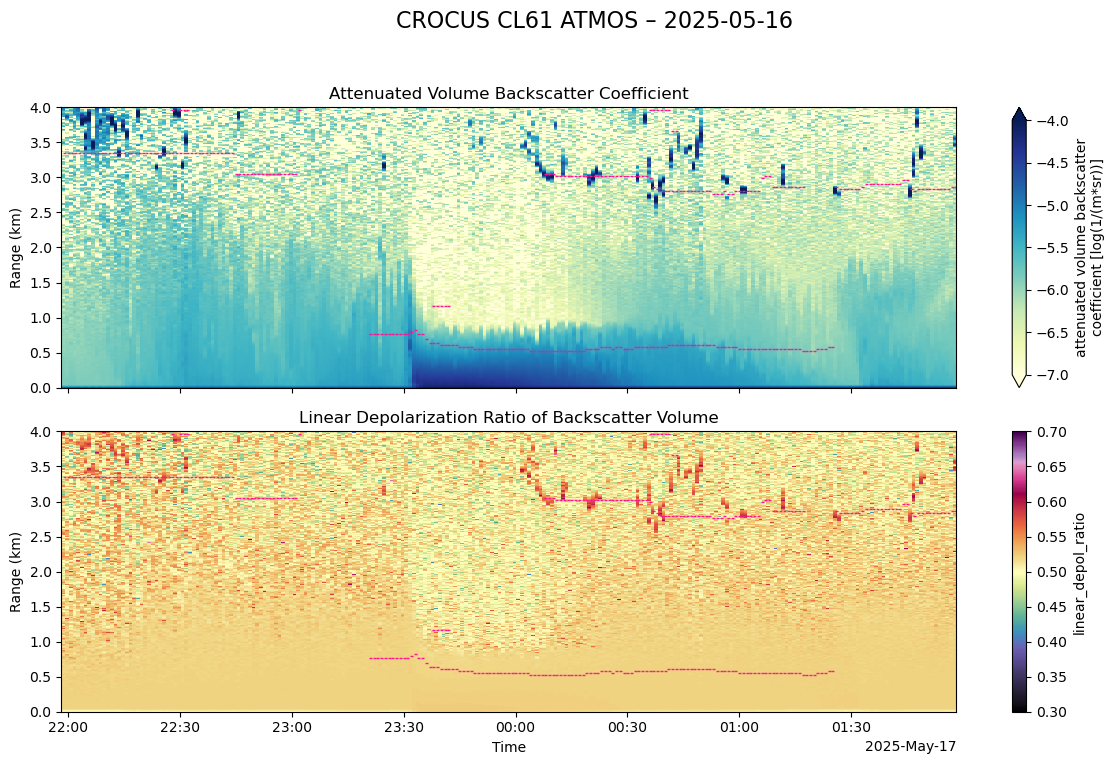

In [41]:
plot_site_data(site_datasets['ATMOS'], site='ATMOS')

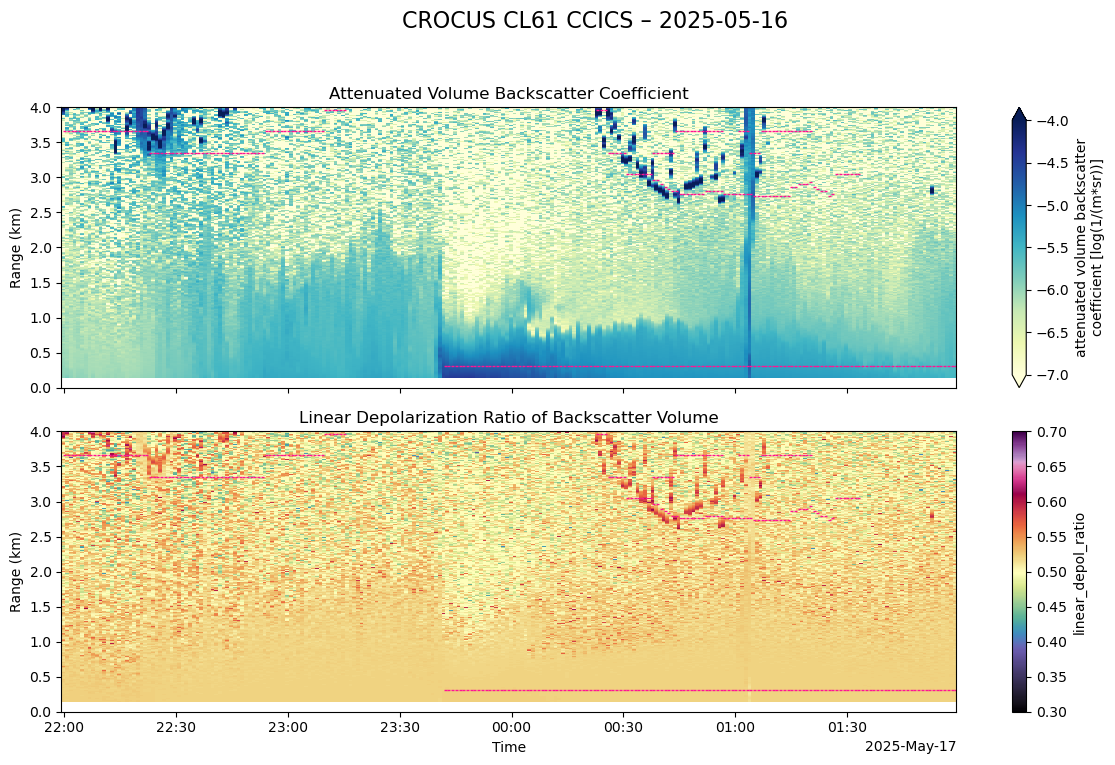

In [42]:
plot_site_data(site_datasets['CCICS'], site='CCICS')

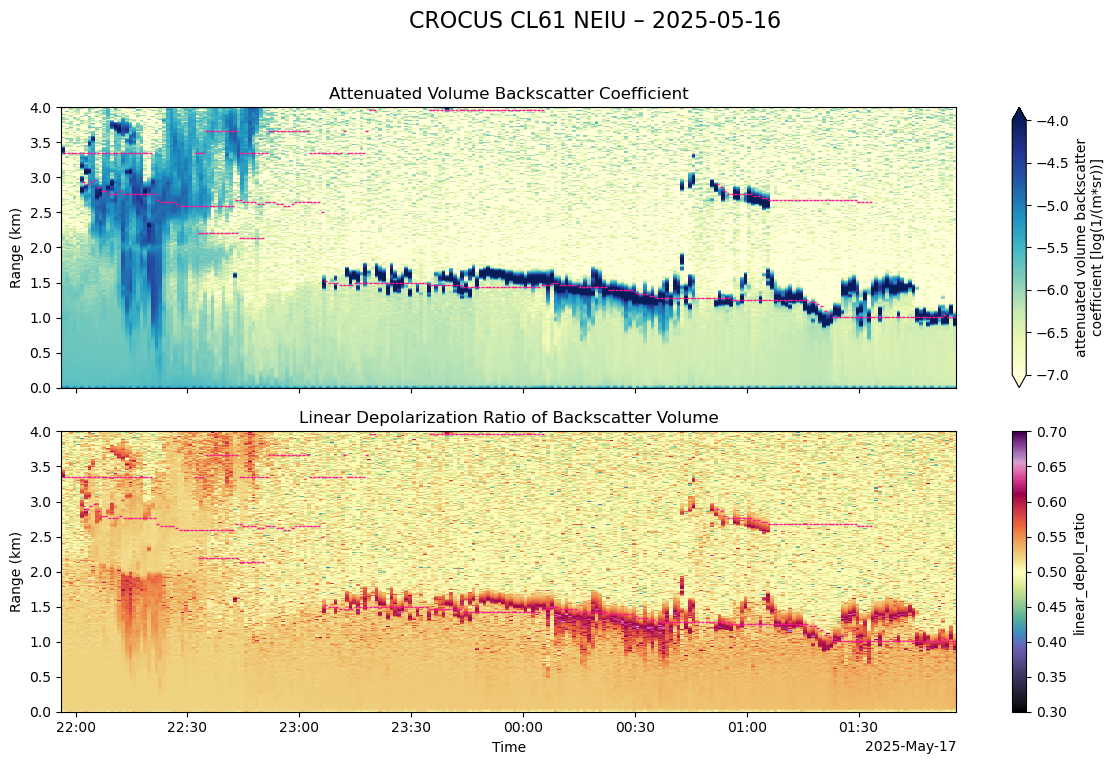

In [43]:
plot_site_data(site_datasets['NEIU'], site='NEIU')